<a href="https://colab.research.google.com/github/AlexanderShukhman/ActiveCitizen2/blob/master/%D0%A5%D0%B0%D0%BA%D0%B0%D1%82%D0%BE%D0%BD_bert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Классификация сообщений о ЧС с помощью BERT

Классификатор построим на предобученной модели BERT. Так как тексты на русском языке, возьмём модель **RuBert** от DeepPavlov. Для реализации всего процесса будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от huggingface, которая позволяет быстро реализовать тот или иной вид Трансформера.

Для дообучения модели используем набор данных Emergency. 
Берт использует собственную разметку токенов. Мы будем использовать уже имеющийся предобученный токенизатор.

Токенизатор разбивает слова на подслова, благодаря чему обученная модель сможет хорошо понимать слова с опечатками и ошибками, а также сможет обрабатывать возможные новые слова. 

Использование предобученных языковых моделей показало очень хорошие результаты для решения большого количества задач при работе с текстами. Языковые модели обучаются на очень большом количестве текстов различной тематики, запоминая особенности языка и взаимосвязи между словами. Потом предобученную модель можно использовать на своём, небольшом датасете для решения конкретной задачи. При этом, нам уже не требуется больших вычислительных ресурсов для получения качественного результата, что значительно ускоряет и удешевляет процесс разработки конечного продукта. Разработчики Берта рекомендуют дообучать предобученную модель совсем немного: достаточно 2 - 4 эпох для получения качественного результата.

## Подключение библиотек

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install huggingface_hub

     |████████████████████████████████| 2.8 MB 4.1 MB/s 
     |████████████████████████████████| 3.3 MB 34.6 MB/s 
     |████████████████████████████████| 895 kB 43.0 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 636 kB 46.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
from random import randint
import torch
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler,
                              SequentialSampler
                              )

from keras.preprocessing.sequence import pad_sequences

from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import AdamW
import huggingface_hub


from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Узнаем, что за карта
print(torch.cuda.get_device_name(0))

Tesla K80


# Подготовка датасета

В качестве основного фреймворка для обучения модели мы используем Pytorch, поэтому будем пользоваться его инструментами формирования датасета и подачи батчей модели.

Pytorch предоставляет возможность использовать различные виды датасетов. Так как наша выборка небольшая, мы сразу загрузим её в память и преобразуем в тензоры, которые будут подаваться модели.

In [ ]:
!gdown  https://drive.google.com/uc?id=1LqpweIxAfMtk1azESstBCWH1osCqt1HO



Downloading...
From: https://drive.google.com/uc?id=1LqpweIxAfMtk1azESstBCWH1osCqt1HO
To: /content/Emergency-3.zip
100% 316k/316k [00:00<00:00, 4.97MB/s]


In [ ]:
!unzip /content/Emergency-3.zip

Archive:  /content/Emergency-3.zip
   creating: Emergency/
   creating: Emergency/train/
   creating: Emergency/train/ambulance/
  inflating: Emergency/train/ambulance/1.txt  
  inflating: Emergency/train/ambulance/10.txt  
  inflating: Emergency/train/ambulance/100.txt  
  inflating: Emergency/train/ambulance/101.txt  
  inflating: Emergency/train/ambulance/102.txt  
  inflating: Emergency/train/ambulance/103.txt  
  inflating: Emergency/train/ambulance/104.txt  
  inflating: Emergency/train/ambulance/105.txt  
  inflating: Emergency/train/ambulance/106.txt  
  inflating: Emergency/train/ambulance/107.txt  
  inflating: Emergency/train/ambulance/108.txt  
  inflating: Emergency/train/ambulance/109.txt  
  inflating: Emergency/train/ambulance/11.txt  
  inflating: Emergency/train/ambulance/110.txt  
  inflating: Emergency/train/ambulance/111.txt  
  inflating: Emergency/train/ambulance/112.txt  
  inflating: Emergency/train/ambulance/113.txt  
  inflating: Emergency/train/ambulance/114

In [ ]:
all_data = load_files('Emergency/train/', encoding='utf-8', decode_error='strict', random_state=42)


In [ ]:
all_data

{'DESCR': None,
 'data': ['Нам нужна пожарная, возможно пожар, в подъезде сильное задымление.',
  'Срочно нужна помощь! Мой дядя чинил розетку и его ударило током. Он лежит. Я не знаю, что делать. Я боюсь подойти. ',
  'С подоконника упал, кровь течет из головы. Возле виска. Сильно. На руках держу, что делать не знаю. Хорошо, перевезала. Он всё равно плачет. Собираемся.',
  'Полиция, в общественном месте, на детской площадке, трое мужчин распивают водку.',
  'роботник газовой службы, не соблюдая технику безопасности, подорзвался на газопроводе, тем самым ему оторвало ногу',
  'Помогите!!! Мы с братом катались на велосипедах потом он с него упал и сейчас у него из головы идет кровь.Я не знаю что делать.Приезжайте быстро',
  'Примите, пожалуйста вызов! Маме плохо, боль в паховой области при движении ногой, она не может, лежа на спине, слегка приподнять правую ногу.',
  'ъеъ, мужик пьяный упал с 4 этажа лежит не встает, давайте сюда',
  'С телефоном в ванную залез и телефон выронил наверн

In [ ]:
sentences = all_data['data']

In [ ]:
labels = all_data['target']

In [ ]:
(labels == 0).sum()


573

In [ ]:
sentences[:5]

['Нам нужна пожарная, возможно пожар, в подъезде сильное задымление.',
 'Срочно нужна помощь! Мой дядя чинил розетку и его ударило током. Он лежит. Я не знаю, что делать. Я боюсь подойти. ',
 'С подоконника упал, кровь течет из головы. Возле виска. Сильно. На руках держу, что делать не знаю. Хорошо, перевезала. Он всё равно плачет. Собираемся.',
 'Полиция, в общественном месте, на детской площадке, трое мужчин распивают водку.',
 'роботник газовой службы, не соблюдая технику безопасности, подорзвался на газопроводе, тем самым ему оторвало ногу']

# Токенизация

Теперь подготовленный датасет нужно токенизировать. Для этого мы воспользуемся уже предобученным токенизатором, идущим вместе с моделью от DeepPavlov.

Каждый сэмпл мы приведём к виду, который требуется Берту, затем разобъём выборку на обучающую и отложенную, для последующей проверки качества.

Специальные токены Берта:

* `[CLS]` - начало последовательности
* `[SEP]` - разделение двух предложений

Мы будем обрамлять наши сэмплы этими токенами.


In [ ]:
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [ ]:
train_sentences, test_sentences, train_category, test_category = train_test_split(sentences, labels, test_size=0.25, stratify=labels, random_state = 42)

In [ ]:
len(train_sentences), len(test_sentences)

(813, 271)

In [ ]:
train_sentences[:5]

['[CLS] \r\nпомогите машина взорвалась возле жилого дома здесь двое раненых нужна срочная помощь\r\n\r\nмужчина упал он без сознания и уже пять минут не приходит в себя помогите\r\n\r\nздравствуйте здесь девушка слишком бледная и с очень сильным кашлем мне кажется у нее коронавирус\r\n\r\nсрочно нужна помощь здесь мужчина лежит на дороге с пулевым ранением в ногу ему очень плохо\r\n\r\nсрочно помогите машина перевернулась там трое детей и девушка\r\n\r\nпомогите срочно здесь дедушка у него седечный приступ\r\n\r\n\r\n\r\n [SEP]',
 '[CLS] Кожа на щиках побелела, что делать? Ничего не чувствую когда касаюсь, а дыра в щеке не останется [SEP]',
 '[CLS] Две девушки дерутся возле ресторана Пикадили. Мужчин рядом нет, разнять некому, одежду рвут и ругаются. [SEP]',
 '[CLS] Мне нужна скорая, жутко болит голова, рвота, слабость. [SEP]',
 '[CLS] Машина грузовая на полном ходу в толпу на остановке въехала, все кричат. Крови много. Приезжайте быстрее. Человек 6 лежит на земле, остальные расходятся

Теперь загрузим наш токенизатор. Он идёт вместе с предобученной моделью [RuBert от DeepPavlov](https://huggingface.co/DeepPavlov/rubert-base-cased).

Загружать будем с помощью универсального метода Pytorch `torch.hub.load`.

In [ ]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'DeepPavlov/rubert-base-cased-conversational')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


In [ ]:
# Токенизируем нашу обучающую выборку
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

In [ ]:
# Посмотрим, что получилось
# Сомволы номеров отмечают то, что данный токен - продолжение слова
print(tokenized_texts[42])

['[CLS]', 'Помогите', ',', 'у', 'меня', 'но', '##ющая', 'боль', 'и', 'жж', '##ение', 'за', 'груди', '##ной', ',', 'тяжело', 'говорить', ',', 'дышать', 'и', 'двигаться', '.', 'Я', 'выпила', 'нитро', '##гли', '##церин', ',', 'но', 'легче', 'не', 'стало', '.', '[SEP]']


In [ ]:
# индексы токенов
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Теперь нам нужно выбрать размер входной последовательности, подаваемой нейросети. Он должен быть фиксированным, но наши сэмплы имеют различную длину.

Поэтому посмотрим на распределение количества токенов в сэмплах и попытаемся определить оптимальный размер. В нашей задаче используются короткие последовательности, поэтому мы можем брать максимальную длину, в других же задачах это может быть критично - мы должны учитывать контекст по максимуми, при этом нужно учитывать, хватит ли машине памяти для обработки последовательностей большого размера.

Выбрав размер, мы приведём все сэмплы к единому виду: последовательности большого размера будут образаны, последовательности малого размера дополнятся паддингами - специальными нулевыми токенами.

(array([421., 271.,  77.,  24.,  11.,   7.,   1.,   0.,   0.,   1.]),
 array([  4. ,  19.4,  34.8,  50.2,  65.6,  81. ,  96.4, 111.8, 127.2,
        142.6, 158. ]),
 <a list of 10 Patch objects>)

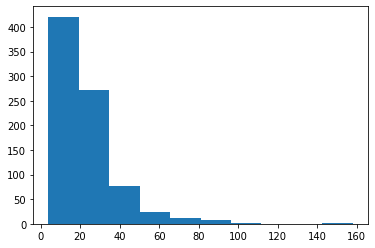

In [ ]:
# Соберём все размеры последовательностей
lenths = [len(sent) for sent in tokenized_texts]
# Посмотрим, как они распределяются
plt.hist(lenths)

In [ ]:
# Выравниваем датасет. Возьмём размер, равный 60
input_ids = pad_sequences(
    input_ids,
    # максимальная длина предложения
    maxlen=60,
    dtype='long',
    truncating='post',
    padding='post'
)

In [ ]:
# Вот, что у нас в результате получилось
# Как видно, в этом примере меньше 60 токенов, поэтому в конец был добавлен паддинг
input_ids[42]

array([  101, 21843,   128,   352,  1021,   876,  3239,  1024,   322,
       18372,   938,   823, 18103,  1014,   128,  4794,  2721,   128,
       20707,   322, 12529,   132,   478, 73955, 88526,  1881, 93235,
         128,   876,  7145,   802,  3169,   132,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])

In [ ]:
# Создадим маску внимания для каждого сэмпла нашей обучающей выборки.
# единицами отметим те токены, которые нужно учитывать при обучении и вычислении градиентов,
# нулями - те, которые следует пропустить.
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
print(attention_masks[42])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# каждая маска соответсвует своей последовательности
assert len(input_ids[42]) == len(attention_masks[42])

Теперь разобъём наш трейн на собственно обучающую выборку и валидационную - для того, чтобы проверять качество в ходе дообучения модели: нужно разделить как последовательности, так и их маски.

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_category, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [ ]:
assert len(train_inputs) == len(train_labels) == len(train_masks)
assert len(validation_inputs) == len(validation_labels) == len(validation_masks)

## Инициализация DataLoader'ов

Переведём все наши данные в тип Тензор, с которым работает Pytorch и инициализируем уже готовый DataLoader из этой библиотеки.

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

В ходе экспериментов можно подобрать разные размеры батча. Но нужно учитывать то, что при больших размерах батча на видеокарте может не хватить памяти, при слишком же малых размерах батча обучение будет нестабильным. Разработчики Берта рекомендуют брать батч размером 32, мы же возьмём 16, так как наши последовательности не очень большие.

In [ ]:
# специальная обёртка для работы с Тензор-датасетами, в Pytorch есть и другие,
# также можно и свою обёртку написать, для нашей же задачи вполне хватит уже существующих
# в библиотеке инструментов. Используя их мы существенно сокращаем свой код.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data),
    batch_size=16
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=16
)

# Дообучение

Загружаем веса предобученной модели и запускаем процесс дообучения на наших данных.

Так как в результате мы хотим получить не языковую модель, а классификатор, укажем это при настройках.

В библиотеке Transformers уже имплементированы классы для различных задач. Нам понадобится `AutoModelForSequenceClassification`.

Использовав этот класс, мы возьмём предобученный Берт, добавив ему на выход один полносвязный слой, который и будет решать нашу задачу классификации. По умолчанию обёртка `AutoModelForSequenceClassification` (или `BertForSequenceClassification`) использует бинарную классификацию.

In [ ]:
config = AutoConfig.from_pretrained('DeepPavlov/rubert-base-cased-conversational', num_labels=3)

In [ ]:
# Загружаем модель, передаём ей наш конфиг
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased-conversational', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Отправим на видеокарту, заодно посмотрим архитектуру нашего Берта
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Видим, что к выходу Берта был добавлен слой:

```(classifier): Linear(in_features=768, out_features=3, bias=True)```

На выходе получим 3 вероятности принадлежности текста той или иной метке.

In [ ]:
# Гипепараметры модели. Их можно изменять
param_optimizer = list(model.named_parameters())

In [ ]:
# Можно посмотреть или изменить. Но нам этого не нужно, инициализируем лишь функцию
# оптимизации. В качестве оптимизатора будем использовать оптимизированный 
# Adam (adaptive moment estimation)
# for name, _ in param_optimizer:
#     print(name)

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

Как говорилось выше, для получения хорошего результата достаточно 4 эпох, но мы посмотрим 8 эпох.

In [ ]:
%%time

# Переводим модель в training mode
model.train()
train_loss_set = []
val_loss_set = []

for epoch in range(12):

  train_loss = 0
  val_loss = 0

  for step1, batch in enumerate(train_dataloader):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Обнуляем градиенты
    optimizer.zero_grad()
    
    # Прогоняем данные по слоям нейросети
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    # Обратный прогон
    loss[0].backward()
    
    # Шаг
    optimizer.step()

    # Обновляем функцию потерь
    print(f'Step: {step1} Loss: {loss[0].item()}')
    train_loss += loss[0].item()
 

  for step2, batch in enumerate(validation_dataloader):   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Прогоняем данные по слоям нейросети
    # Вычислять градиенты не нужно
    with torch.no_grad():
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    val_loss += loss[0].item()

  train_loss = train_loss / (step1 + 1) 
  val_loss = val_loss / (step2 + 1)
  train_loss_set.append(train_loss)  
  val_loss_set.append(val_loss)  
  print(f'Эпоха {epoch} - train_loss: {train_loss}, val_loss: {val_loss}')

Step: 0 Loss: 1.0821852684020996
Step: 1 Loss: 1.0051246881484985
Step: 2 Loss: 1.1161706447601318
Step: 3 Loss: 0.9953690767288208
Step: 4 Loss: 0.9301103353500366
Step: 5 Loss: 0.9920605421066284
Step: 6 Loss: 0.8940277695655823
Step: 7 Loss: 1.0302931070327759
Step: 8 Loss: 0.9939684271812439
Step: 9 Loss: 1.0654637813568115
Step: 10 Loss: 0.8919543027877808
Step: 11 Loss: 0.7801419496536255
Step: 12 Loss: 0.9219332337379456
Step: 13 Loss: 0.8752487301826477
Step: 14 Loss: 0.8248918056488037
Step: 15 Loss: 0.7410828471183777
Step: 16 Loss: 0.829407811164856
Step: 17 Loss: 0.7858509421348572
Step: 18 Loss: 0.5168942809104919
Step: 19 Loss: 0.6763367652893066
Step: 20 Loss: 0.5594652891159058
Step: 21 Loss: 0.7370687127113342
Step: 22 Loss: 0.548279881477356
Step: 23 Loss: 0.50572669506073
Step: 24 Loss: 0.419583797454834
Step: 25 Loss: 0.4680858552455902
Step: 26 Loss: 0.389110803604126
Step: 27 Loss: 0.5277181267738342
Step: 28 Loss: 0.7363309264183044
Step: 29 Loss: 0.5587626695632

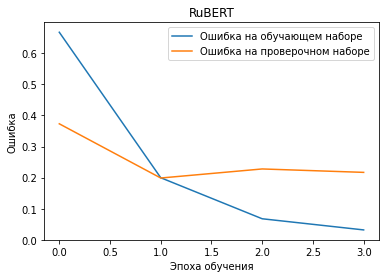

In [ ]:
# посмотрим, как обучалась наша модель
plt.plot(train_loss_set, 
         label='Ошибка на обучающем наборе')
plt.plot(val_loss_set, 
         label='Ошибка на проверочном наборе')
plt.title("RuBERT")
plt.xlabel("Эпоха обучения")
plt.ylabel("Ошибка")
plt.legend()
plt.show()

# Валидация

Проверим работу модели на отложенной выборке.

In [ ]:
%time

# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch

    
    
    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


Посмотрим на качество нашей модели по каждой из категорий. Как видно, при определении каждой из категорий, наша модель справляется сравнительно хорошо. И это даже при том, что мы использовали несбалансированную выборку.

In [ ]:
print(classification_report(valid_labels, valid_preds, digits = 4))

              precision    recall  f1-score   support

           0     1.0000    0.9130    0.9545        46
           1     0.8750    0.9545    0.9130        22
           2     0.8125    0.9286    0.8667        14

    accuracy                         0.9268        82
   macro avg     0.8958    0.9321    0.9114        82
weighted avg     0.9345    0.9268    0.9284        82



# Проверка дообученной модели


С помощью дообученной модели можно определять классы сообщений на  CPU. Проверим качество на тестовых данных.

In [ ]:
%%time

model.to('cpu')
model.eval()

pred_cat = []
for title in test_sentences:
    tokens = tokenizer.encode(title, add_special_tokens=False)
    tokens_tensor = torch.tensor([tokens])
    with torch.no_grad():
        logits = model(tokens_tensor)
    # Логиты по каждой категории
    logits = logits[0].detach().numpy()
    # Выбираем наиболее вероятную категорию
    predicted_class = np.argmax(logits, axis=1)
    pred_cat.append(predicted_class[0])

CPU times: user 29.2 s, sys: 418 ms, total: 29.6 s
Wall time: 29.6 s


In [ ]:
print(classification_report(test_category, pred_cat, digits = 4))

              precision    recall  f1-score   support

           0     0.9847    0.9021    0.9416       143
           1     0.9444    1.0000    0.9714        85
           2     0.8200    0.9535    0.8817        43

    accuracy                         0.9410       271
   macro avg     0.9164    0.9519    0.9316       271
weighted avg     0.9460    0.9410    0.9415       271



## Примеры классификации 

In [ ]:
label_names = all_data["target_names"]

text = ''
tokens = tokenizer.encode(text, add_special_tokens=True)
tokens_tensor = torch.tensor([tokens])
with torch.no_grad():
    logits = model(tokens_tensor)
logits = logits[0].detach().numpy()
print(logits)
predicted_class = np.argmax(logits, axis=1)
print(f'Сообщение: {text}')
print(f'Предсказанная категория: {label_names[predicted_class[0]]}')

text = 'Не могу измерить температуру ребенку. Но он горячий'
tokens = tokenizer.encode(text, add_special_tokens=True)
tokens_tensor = torch.tensor([tokens])
with torch.no_grad():
    logits = model(tokens_tensor)
logits = logits[0].detach().numpy()
predicted_class = np.argmax(logits, axis=1)
print(f'Сообщение: {text}')
print(f'Предсказанная категория: {label_names[predicted_class[0]]}')




[[-1.1774477   1.4220269   0.21467762]]
Сообщение: сникерс и баунти - что может быть лучше
Предсказанная категория: fire
Сообщение: Не могу измерить температуру ребенку. Но он горячий
Предсказанная категория: ambulance


In [ ]:
model.save_pretrained('/content/drive/MyDrive/BERT_model/')
tokenizer.save_pretrained('/content/drive/MyDrive/BERT_model/')

('/content/drive/MyDrive/BERT_model/tokenizer_config.json',
 '/content/drive/MyDrive/BERT_model/special_tokens_map.json',
 '/content/drive/MyDrive/BERT_model/vocab.txt',
 '/content/drive/MyDrive/BERT_model/added_tokens.json')

In [ ]:
# config
config = AutoConfig.from_pretrained('/content/drive/MyDrive/BERT_model')
# tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/BERT_model', pad_to_max_length=True)
# model
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/BERT_model', config=config)


In [ ]:
model.to('cpu')
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
label_names = all_data["target_names"]

text = 'Драка, шум, много народу бегают вокруг дома'
tokens = tokenizer.encode(text, add_special_tokens=True)
tokens_tensor = torch.tensor([tokens])
with torch.no_grad():
    logits = model(tokens_tensor)
logits = logits[0].detach().numpy()
predicted_class = np.argmax(logits, axis=1)
print(f'Сообщение: {text}')
print(f'Предсказанная категория: {label_names[predicted_class[0]]}')

text = 'Не могу измерить температуру ребенку. Но он горячий'
tokens = tokenizer.encode(text, add_special_tokens=True)
tokens_tensor = torch.tensor([tokens])
with torch.no_grad():
    logits = model(tokens_tensor)
logits = logits[0].detach().numpy()
predicted_class = np.argmax(logits, axis=1)
print(f'Сообщение: {text}')
print(f'Предсказанная категория: {label_names[predicted_class[0]]}')


Сообщение: Драка, шум, много народу бегают вокруг дома
Предсказанная категория: police
Сообщение: Не могу измерить температуру ребенку. Но он горячий
Предсказанная категория: ambulance
